# Kaggle
## Competição DSA de Machine Learning - Dezembro 2019

Versão 1.0.0: LB = 0.50557
- modelo: XGBoost (com algumas otimizações)
- features categoricas: removido
- dados missing: atribuído o valor medio

Versão 1.0.1: LB = 0.48972 / CV = 0.469777
- modelo: XGBoost executando todas as otimizações
- features engineering: gerado através do Auto_ViML

Versão 1.0.2: LB = 0.55264 / CV = 0.469158
- modelo: XGBoost executando todas as otimizações
- dados missing: removido colunas com mais de 40% de NA e as demais -999
- features categoricas: label encoder
- feature engineering: usando pacote Boruta

Versão 1.0.3: LB = ??? / CV = ???
- modelo: XGBoost executando todas as otimizações
- features engineering: gerado através do Auto_ViML (modificado v1)

## 1. Importando as bibliotecas

In [1]:
# Importar os principais pacotes
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
%matplotlib inline

import time
import datetime
import gc

# Evitar que aparece os warnings
import warnings
warnings.filterwarnings("ignore")

# Seta algumas opções no Jupyter para exibição dos datasets
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# Variavel para controlar o treinamento no Kaggle
TRAIN_OFFLINE = True

In [2]:
# Importa os pacotes de algoritmos
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import lightgbm as lgb

# Importa pacotes do sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, log_loss
from sklearn.preprocessing import scale, MinMaxScaler, StandardScaler


## 2. Carregando os dados de treino e teste

In [3]:
def read_data():
    
    if TRAIN_OFFLINE:
        print('Carregando arquivo dataset_treino.csv....')
        train = pd.read_csv('../dataset/dataset_treino_modificado.csv')
        print('dataset_treino.csv tem {} linhas and {} colunas'.format(train.shape[0], train.shape[1]))
        
        print('Carregando arquivo dataset_teste.csv....')
        test = pd.read_csv('../dataset/dataset_teste_modificado.csv')
        print('dataset_teste.csv tem {} linhas and {} colunas'.format(test.shape[0], test.shape[1]))
        
    else:
        print('Carregando arquivo dataset_treino.csv....')
        train = pd.read_csv('/kaggle/input/competicao-dsa-machine-learning-dec-2019/dataset_treino.csv')
        print('dataset_treino.csv tem {} linhas and {} colunas'.format(train.shape[0], train.shape[1]))
        
        print('Carregando arquivo dataset_treino.csv....')
        test = pd.read_csv('/kaggle/input/competicao-dsa-machine-learning-dec-2019/dataset_teste.csv')
        print('dataset_teste.csv tem {} linhas and {} colunas'.format(test.shape[0], test.shape[1]))
    
    return train, test

In [4]:
# Leitura dos dados
train, test = read_data()

Carregando arquivo dataset_treino.csv....
dataset_treino.csv tem 114321 linhas and 44 colunas
Carregando arquivo dataset_teste.csv....
dataset_teste.csv tem 114393 linhas and 51 colunas


In [6]:
test = test[test.columns[:-8]]

In [7]:
# Juntando os dois dataset (treino e teste)
df = train.append(test)
df.shape

(228714, 44)

In [8]:
# Verificar a quantidade de features numericas e categoricas

numerical_feats = df.dtypes[df.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = df.dtypes[df.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  44
Number of Categorical features:  0


## 3. Feature Engineering

In [10]:
new_df = df.copy()

In [11]:
# Create correlation matrix
corr_matrix = new_df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
to_drop

['v106', 'v91', 'v95']

In [12]:
# Drop features 
new_df = new_df.drop(new_df[to_drop], axis=1)
new_df.shape

(228714, 41)

## 4. Criar e avaliar alguns algoritmos de Machine Learning

In [14]:
# Separar o dataset de treino e teste
treino = new_df[new_df['target'].notnull()]
teste  = new_df[new_df['target'].isnull()]

# Separando features preditoras e target
#X_ = treino.drop(['ID','target'], axis=1)
X = treino.drop(['target'], axis=1)
y = treino['target']

# Padronizando os dados de treino
scaler = StandardScaler()
X = scaler.fit_transform(X)

## 4.1. Algoritmo XGBoost - Extreme Gradient Boosting

Vamos dar uma olhada nas vantagens desse algoritmo:

***Regularização:***
- O XGBoost também é conhecido como uma técnica de "reforço regularizado", ajudando a reduzir o overfitting

***Processamento paralelo:***
- O XGBoost implementa o processamento paralelo e é incrivelmente mais rápido em comparação com o GBM. Mas, espere, sabemos que impulsionar é um processo seqüencial; portanto, como ele pode ser paralelo? Sabemos que cada árvore pode ser construída somente após a anterior, então o que nos impede de fazer uma árvore usando todos os núcleos?

***Alta flexibilidade***
- O XGBoost permite que os usuários definam objetivos de otimização personalizados e critérios de avaliação. Isso adiciona uma nova dimensão ao modelo e não há limite para o que podemos fazer.

***Tratamento de valores ausentes***
- O XGBoost possui uma rotina integrada para lidar com os valores ausentes. É necessário que o usuário forneça um valor diferente de outras observações e passe isso como um parâmetro. O XGBoost tenta coisas diferentes ao encontrar um valor ausente em cada nó e descobre qual caminho seguir para valores ausentes no futuro.

***Poda de árvores:***
- O XGBoost faz divisões até a profundidade máxima especificada e, em seguida, começa a podar a árvore para trás e remove as divisões além das quais não há ganho positivo.

***Validação cruzada incorporada***
- O XGBoost permite que o usuário execute uma validação cruzada a cada iteração do processo de otimização e, portanto, é fácil obter o número ideal exato de iterações de otimização em uma única execução.

- Você pode começar a treinar um modelo XGBoost a partir da última iteração da execução anterior. Isso pode ser uma vantagem significativa em certas aplicações específicas.

In [15]:
# Criando uma funcao para criação, execução e validação do modelo
def run_model(modelo, X_tr, y_tr, useTrainCV=True, cv_folds=5, early_stopping_rounds=10):
    
    # Utilização do Cross-Validation
    if useTrainCV:
        xgb_param = modelo.get_xgb_params()
        xgtrain = xgb.DMatrix(X_tr, label=y_tr)
        
        print ('Start cross validation')
        cvresult = xgb.cv(xgb_param, 
                          xgtrain, 
                          num_boost_round=modelo.get_params()['n_estimators'], 
                          nfold=cv_folds,
                          metrics=['logloss'],
                          stratified=True,
                          seed=42,
                          verbose_eval=True,
                          early_stopping_rounds=early_stopping_rounds)

        modelo.set_params(n_estimators=cvresult.shape[0])
        best_tree = cvresult.shape[0]
        print('Best number of trees = {}'.format(best_tree-1))
    
    # Fit do modelo
    modelo.fit(X_tr, y_tr, eval_metric='logloss')
        
    # Predição no dataset de treino
    train_pred = modelo.predict(X_tr)
    train_pred_prob = modelo.predict_proba(X_tr)[:,1]
    
    # Exibir o relatorio do modelo
    print("Log Loss (Treino): %f" % log_loss(y_tr, train_pred_prob))
    print("Log Loss (Test): %f" % cvresult['test-logloss-mean'][best_tree-1])
    
    feature_imp = pd.Series(modelo.feature_importances_.astype(float)).sort_values(ascending=False)
    
    plt.figure(figsize=(18,8))
    feature_imp[:25].plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.tight_layout()

#### Passo 01: criando o modelo fixando alguns hyperparametros

Start cross validation
[0]	train-logloss:0.657985+6.5344e-05	test-logloss:0.658123+5.55503e-05
[1]	train-logloss:0.629268+0.000139079	test-logloss:0.629581+0.000285121
[2]	train-logloss:0.605597+0.00012119	test-logloss:0.606032+0.00034454
[3]	train-logloss:0.586958+0.00113957	test-logloss:0.587518+0.00136422
[4]	train-logloss:0.57072+0.000872234	test-logloss:0.571361+0.00125731
[5]	train-logloss:0.556786+0.000977906	test-logloss:0.557522+0.00142933
[6]	train-logloss:0.544882+0.00101291	test-logloss:0.5457+0.00152702
[7]	train-logloss:0.534994+0.00051075	test-logloss:0.535947+0.0012127
[8]	train-logloss:0.526818+0.000605795	test-logloss:0.527868+0.00135067
[9]	train-logloss:0.519485+0.000335372	test-logloss:0.520657+0.000955509
[10]	train-logloss:0.512944+0.000249216	test-logloss:0.514258+0.000923244
[11]	train-logloss:0.507447+0.000290672	test-logloss:0.508879+0.000809252
[12]	train-logloss:0.502747+0.000405154	test-logloss:0.504318+0.000838004
[13]	train-logloss:0.49892+0.000219762	te

[113]	train-logloss:0.450973+0.000561941	test-logloss:0.46734+0.00148818
[114]	train-logloss:0.450734+0.00057994	test-logloss:0.467326+0.00147842
[115]	train-logloss:0.450573+0.000575286	test-logloss:0.467294+0.00146557
[116]	train-logloss:0.450398+0.000603244	test-logloss:0.467285+0.00145265
[117]	train-logloss:0.450223+0.000583464	test-logloss:0.467254+0.00145382
[118]	train-logloss:0.450062+0.000579471	test-logloss:0.467226+0.00144355
[119]	train-logloss:0.449889+0.000579521	test-logloss:0.467227+0.0014581
[120]	train-logloss:0.449745+0.000569488	test-logloss:0.467206+0.00147341
[121]	train-logloss:0.449583+0.000537466	test-logloss:0.467185+0.00144183
[122]	train-logloss:0.4494+0.000528002	test-logloss:0.467171+0.00144565
[123]	train-logloss:0.449281+0.000543053	test-logloss:0.467164+0.00146119
[124]	train-logloss:0.449084+0.000532116	test-logloss:0.467147+0.00147683
[125]	train-logloss:0.448892+0.000527323	test-logloss:0.467132+0.00148547
[126]	train-logloss:0.448708+0.000574348	te

[225]	train-logloss:0.433616+0.0007574	test-logloss:0.465739+0.00171821
[226]	train-logloss:0.433464+0.000750411	test-logloss:0.465735+0.00169853
[227]	train-logloss:0.433327+0.000733434	test-logloss:0.465711+0.00168228
[228]	train-logloss:0.433201+0.000730662	test-logloss:0.465723+0.00170463
[229]	train-logloss:0.433055+0.000737424	test-logloss:0.465709+0.00170503
[230]	train-logloss:0.432906+0.000782685	test-logloss:0.465713+0.00169821
[231]	train-logloss:0.432738+0.000813377	test-logloss:0.465696+0.00170663
[232]	train-logloss:0.432599+0.000811016	test-logloss:0.465681+0.00172591
[233]	train-logloss:0.432487+0.000810094	test-logloss:0.465679+0.00173972
[234]	train-logloss:0.432354+0.000827999	test-logloss:0.465694+0.00175003
[235]	train-logloss:0.432226+0.000817888	test-logloss:0.465702+0.00175399
[236]	train-logloss:0.43206+0.000787037	test-logloss:0.465688+0.00181313
[237]	train-logloss:0.431945+0.000813883	test-logloss:0.465678+0.00180237
[238]	train-logloss:0.431833+0.000833676	

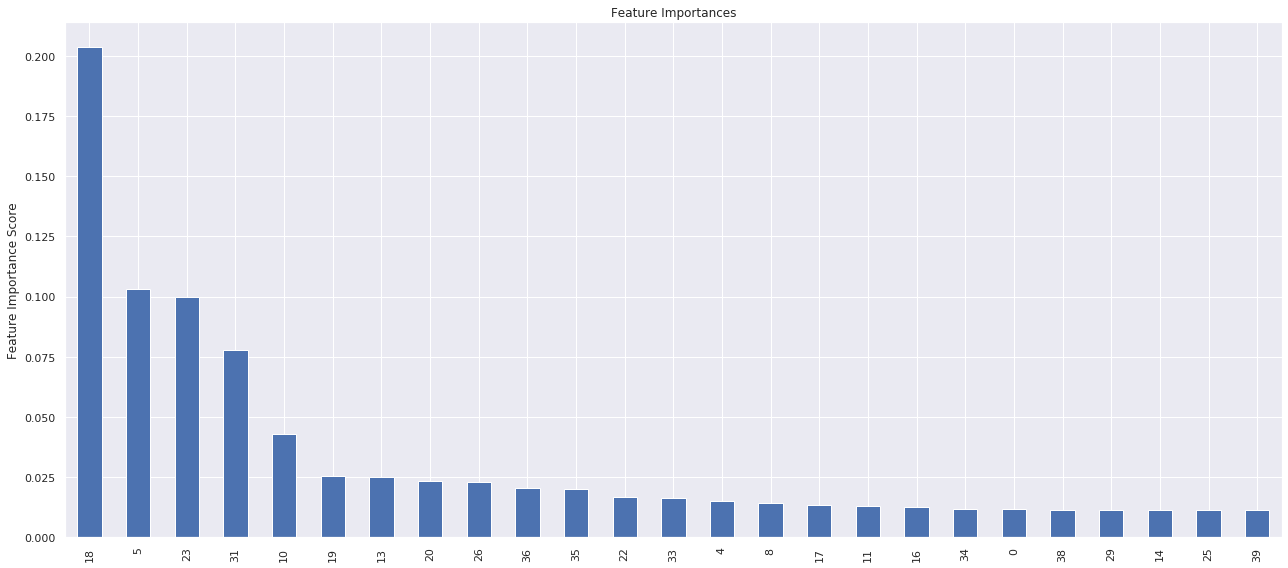

In [16]:
%%time

# Criando o primeiro modelo XGB
modeloXGB = XGBClassifier(learning_rate = 0.1,
                          n_estimators = 1000,
                          max_depth = 5,
                          min_child_weight = 1,
                          gamma = 0,
                          subsample = 0.8,
                          colsample_bytree = 0.8,
                          objective = 'binary:logistic',
                          n_jobs = -1,
                          scale_pos_weight = 1,
                          seed = 42)

run_model(modeloXGB, X, y)

#### Passo 02: otimização dos parametros: max_depth e min_child_weight

In [17]:
%%time

# Definindo os parametros que serão testados no GridSearch
param_v1 = {
 'max_depth':range(2,5),
 'min_child_weight':range(1,2)
}

grid_1 = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.1, 
                                                n_estimators = 1000, 
                                                max_depth = 5,
                                                min_child_weight = 1, 
                                                gamma = 0, 
                                                subsample = 0.8, 
                                                colsample_bytree = 0.8,
                                                objective = 'binary:logistic', 
                                                nthread = 4,
                                                scale_pos_weight = 1, 
                                                seed = 42),
                      param_grid = param_v1, 
                      scoring = 'neg_log_loss',
                      n_jobs = -1,
                      iid = False, 
                      cv = 5)

# Realizando o fit e obtendo os melhores parametros do grid
grid_1.fit(X, y)
grid_1.best_params_, grid_1.best_score_

CPU times: user 2min 37s, sys: 804 ms, total: 2min 38s
Wall time: 4min 50s


({'max_depth': 4, 'min_child_weight': 1}, -0.46648729604509276)

#### Passo 03: otimização dos parametros: gamma

In [18]:
%%time

# Definindo os parametros que serão testados no GridSearch
param_v2 = {
 'gamma':[i/10.0 for i in range(0,2)]
}

grid_2 = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.1, 
                                                n_estimators = 1000, 
                                                max_depth = grid_1.best_params_['max_depth'],
                                                min_child_weight = grid_1.best_params_['min_child_weight'], 
                                                gamma = 0, 
                                                subsample = 0.8, 
                                                colsample_bytree = 0.8,
                                                objective = 'binary:logistic', 
                                                nthread = 4, 
                                                scale_pos_weight = 1, 
                                                seed = 42),
                      param_grid = param_v2, 
                      scoring = 'neg_log_loss',
                      n_jobs = -1,
                      iid = False, 
                      cv = 5)

# Realizando o fit e obtendo os melhores parametros do grid
grid_2.fit(X, y)
grid_2.best_params_, grid_2.best_score_

CPU times: user 2min 38s, sys: 768 ms, total: 2min 38s
Wall time: 4min 28s


({'gamma': 0.1}, -0.4664149411168689)

#### Passo 04: otimização dos parametros: subsample e colsample_bytree

In [19]:
%%time

# Definindo os parametros que serão testados no GridSearch
param_v3 = {
 'subsample':[i/10.0 for i in range(6,8)],
 'colsample_bytree':[i/10.0 for i in range(6,8)]
}

grid_3 = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.1, 
                                                n_estimators = 1000, 
                                                max_depth = grid_1.best_params_['max_depth'],
                                                min_child_weight = grid_1.best_params_['min_child_weight'], 
                                                gamma = grid_2.best_params_['gamma'], 
                                                subsample = 0.8, 
                                                colsample_bytree = 0.8,
                                                objective = 'binary:logistic', 
                                                nthread = 4, 
                                                scale_pos_weight = 1, 
                                                seed = 42),
                      param_grid = param_v3, 
                      scoring = 'neg_log_loss',
                      n_jobs = -1,
                      iid = False, 
                      cv = 5)

grid_3.fit(X, y)
grid_3.best_params_, grid_3.best_score_

CPU times: user 2min 15s, sys: 716 ms, total: 2min 15s
Wall time: 7min 19s


({'colsample_bytree': 0.6, 'subsample': 0.7}, -0.4663307740444621)

#### Passo 05: otimização dos parametros: reg_alpha

In [20]:
%%time

# Definindo os parametros que serão testados no GridSearch
param_v4 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}

grid_4 = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.1, 
                                                n_estimators = 1000, 
                                                max_depth = grid_1.best_params_['max_depth'],
                                                min_child_weight = grid_1.best_params_['min_child_weight'], 
                                                gamma = grid_2.best_params_['gamma'], 
                                                subsample = grid_3.best_params_['subsample'], 
                                                colsample_bytree = grid_3.best_params_['colsample_bytree'],
                                                objective = 'binary:logistic', 
                                                nthread = 4, 
                                                scale_pos_weight = 1, 
                                                seed = 42),
                      param_grid = param_v4, 
                      scoring = 'neg_log_loss',
                      n_jobs = -1,
                      iid = False, 
                      cv = 5)

# Realizando o fit e obtendo os melhores parametros do grid
grid_4.fit(X, y)
grid_4.best_params_, grid_4.best_score_

CPU times: user 3min 12s, sys: 1.35 s, total: 3min 13s
Wall time: 9min 45s


({'reg_alpha': 0}, -0.4663307740444621)

## Passo 06: reduzindo Learning Rate

Start cross validation
[0]	train-logloss:0.683679+0.000103794	test-logloss:0.683682+0.000119699
[1]	train-logloss:0.6742+0.00059698	test-logloss:0.674243+0.000572301
[2]	train-logloss:0.66552+0.000758763	test-logloss:0.665583+0.000696838
[3]	train-logloss:0.65666+0.00084114	test-logloss:0.656744+0.000767
[4]	train-logloss:0.648662+0.00103194	test-logloss:0.648757+0.000923568
[5]	train-logloss:0.640994+0.00113069	test-logloss:0.641111+0.000999483
[6]	train-logloss:0.633921+0.0010071	test-logloss:0.634082+0.000874251
[7]	train-logloss:0.627258+0.00123732	test-logloss:0.627428+0.00108299
[8]	train-logloss:0.620323+0.00124985	test-logloss:0.62052+0.00106802
[9]	train-logloss:0.613891+0.0012314	test-logloss:0.614118+0.00106876
[10]	train-logloss:0.60778+0.00124403	test-logloss:0.608011+0.00106096
[11]	train-logloss:0.602356+0.00128528	test-logloss:0.602604+0.00115296
[12]	train-logloss:0.597103+0.00156993	test-logloss:0.597364+0.00142239
[13]	train-logloss:0.592241+0.00149375	test-logloss:0

[114]	train-logloss:0.476756+0.000418645	test-logloss:0.478761+0.00125189
[115]	train-logloss:0.476586+0.000412	test-logloss:0.478616+0.00125414
[116]	train-logloss:0.476422+0.000442505	test-logloss:0.478471+0.00126151
[117]	train-logloss:0.476259+0.000417741	test-logloss:0.478322+0.00124601
[118]	train-logloss:0.476125+0.000416518	test-logloss:0.478211+0.00125799
[119]	train-logloss:0.475966+0.000396906	test-logloss:0.47807+0.0012729
[120]	train-logloss:0.475822+0.000410692	test-logloss:0.477952+0.00127528
[121]	train-logloss:0.475665+0.000400655	test-logloss:0.47781+0.0012982
[122]	train-logloss:0.475512+0.000435141	test-logloss:0.477673+0.00130544
[123]	train-logloss:0.475364+0.000444801	test-logloss:0.47753+0.00128883
[124]	train-logloss:0.475249+0.00044372	test-logloss:0.477427+0.00132003
[125]	train-logloss:0.475139+0.000442236	test-logloss:0.477341+0.00131999
[126]	train-logloss:0.475005+0.000445746	test-logloss:0.477225+0.00129703
[127]	train-logloss:0.474866+0.000459994	test-l

[226]	train-logloss:0.46733+0.000436421	test-logloss:0.471785+0.00140967
[227]	train-logloss:0.467278+0.000444326	test-logloss:0.471754+0.00141279
[228]	train-logloss:0.467232+0.000451921	test-logloss:0.47173+0.00140292
[229]	train-logloss:0.467157+0.000434876	test-logloss:0.471685+0.00141672
[230]	train-logloss:0.467111+0.000428993	test-logloss:0.471664+0.0014269
[231]	train-logloss:0.467058+0.000434593	test-logloss:0.471636+0.0014169
[232]	train-logloss:0.467015+0.000440159	test-logloss:0.471602+0.00141386
[233]	train-logloss:0.466958+0.000444879	test-logloss:0.471558+0.00141243
[234]	train-logloss:0.466901+0.000445615	test-logloss:0.471524+0.00141168
[235]	train-logloss:0.466859+0.000447406	test-logloss:0.471506+0.00140815
[236]	train-logloss:0.466815+0.000453456	test-logloss:0.471484+0.00141256
[237]	train-logloss:0.466758+0.00045882	test-logloss:0.471462+0.0014145
[238]	train-logloss:0.466699+0.000451746	test-logloss:0.471437+0.00141492
[239]	train-logloss:0.466649+0.000460126	tes

[338]	train-logloss:0.462642+0.000358245	test-logloss:0.469587+0.00148253
[339]	train-logloss:0.462604+0.000351813	test-logloss:0.469566+0.00149623
[340]	train-logloss:0.46256+0.000345232	test-logloss:0.469543+0.00151094
[341]	train-logloss:0.46251+0.000336622	test-logloss:0.469519+0.00151546
[342]	train-logloss:0.462477+0.00033452	test-logloss:0.469509+0.0015164
[343]	train-logloss:0.462449+0.000340038	test-logloss:0.469498+0.00151118
[344]	train-logloss:0.462412+0.000335568	test-logloss:0.46949+0.0015176
[345]	train-logloss:0.462382+0.000335149	test-logloss:0.469493+0.00151717
[346]	train-logloss:0.462347+0.000343743	test-logloss:0.469481+0.00151244
[347]	train-logloss:0.462304+0.000352033	test-logloss:0.469473+0.00150485
[348]	train-logloss:0.462282+0.000352239	test-logloss:0.469467+0.0015065
[349]	train-logloss:0.462244+0.000350979	test-logloss:0.469449+0.00150375
[350]	train-logloss:0.462217+0.000356323	test-logloss:0.469449+0.00150566
[351]	train-logloss:0.462187+0.000351165	test

[450]	train-logloss:0.458956+0.000358084	test-logloss:0.468465+0.00152747
[451]	train-logloss:0.458928+0.000351654	test-logloss:0.46845+0.00152996
[452]	train-logloss:0.458897+0.000352938	test-logloss:0.468449+0.00152868
[453]	train-logloss:0.45887+0.000349942	test-logloss:0.468445+0.00153376
[454]	train-logloss:0.458831+0.000345687	test-logloss:0.468435+0.00152469
[455]	train-logloss:0.458801+0.000350702	test-logloss:0.468421+0.00151773
[456]	train-logloss:0.458776+0.000355569	test-logloss:0.468415+0.0015153
[457]	train-logloss:0.45875+0.000360291	test-logloss:0.46841+0.00151406
[458]	train-logloss:0.458722+0.00035716	test-logloss:0.468405+0.00150823
[459]	train-logloss:0.458696+0.000360734	test-logloss:0.468397+0.00151078
[460]	train-logloss:0.458665+0.00036614	test-logloss:0.468384+0.0015032
[461]	train-logloss:0.45863+0.000369486	test-logloss:0.468368+0.00150501
[462]	train-logloss:0.458595+0.000371182	test-logloss:0.468368+0.00150439
[463]	train-logloss:0.458564+0.00036777	test-lo

[562]	train-logloss:0.455636+0.00036982	test-logloss:0.467634+0.00153404
[563]	train-logloss:0.45561+0.00036453	test-logloss:0.46763+0.00153961
[564]	train-logloss:0.455581+0.000365615	test-logloss:0.467624+0.00153388
[565]	train-logloss:0.455556+0.000365958	test-logloss:0.467625+0.00153761
[566]	train-logloss:0.455522+0.000375185	test-logloss:0.467619+0.00153487
[567]	train-logloss:0.455491+0.000374535	test-logloss:0.467618+0.00153229
[568]	train-logloss:0.455463+0.000372611	test-logloss:0.46761+0.00153104
[569]	train-logloss:0.455435+0.000373094	test-logloss:0.467603+0.00153205
[570]	train-logloss:0.455399+0.00037226	test-logloss:0.467596+0.00153142
[571]	train-logloss:0.455367+0.000369328	test-logloss:0.46759+0.00153938
[572]	train-logloss:0.455336+0.000371048	test-logloss:0.467583+0.00154627
[573]	train-logloss:0.455314+0.000374444	test-logloss:0.467577+0.00154862
[574]	train-logloss:0.45528+0.000382055	test-logloss:0.467567+0.00154306
[575]	train-logloss:0.455256+0.000391482	test-

[674]	train-logloss:0.452555+0.000422565	test-logloss:0.467051+0.00157968
[675]	train-logloss:0.452525+0.000421003	test-logloss:0.467042+0.00158259
[676]	train-logloss:0.452492+0.000423488	test-logloss:0.467034+0.001577
[677]	train-logloss:0.452461+0.000421644	test-logloss:0.467031+0.00157614
[678]	train-logloss:0.452438+0.00042389	test-logloss:0.467026+0.00157615
[679]	train-logloss:0.452417+0.000425188	test-logloss:0.467026+0.00157279
[680]	train-logloss:0.452391+0.000426642	test-logloss:0.467021+0.00157764
[681]	train-logloss:0.452364+0.00042752	test-logloss:0.467015+0.00157512
[682]	train-logloss:0.452338+0.000428995	test-logloss:0.467006+0.0015717
[683]	train-logloss:0.452308+0.000421398	test-logloss:0.467003+0.00158398
[684]	train-logloss:0.452284+0.000416694	test-logloss:0.467001+0.00158681
[685]	train-logloss:0.452259+0.000421895	test-logloss:0.467001+0.00158315
[686]	train-logloss:0.452231+0.000421968	test-logloss:0.466991+0.00157106
[687]	train-logloss:0.452203+0.000428074	te

[786]	train-logloss:0.449702+0.000438984	test-logloss:0.466623+0.00161174
[787]	train-logloss:0.449669+0.000427364	test-logloss:0.46662+0.00162596
[788]	train-logloss:0.449643+0.000429945	test-logloss:0.466617+0.00162874
[789]	train-logloss:0.449617+0.000434083	test-logloss:0.466611+0.00162751
[790]	train-logloss:0.449588+0.00044082	test-logloss:0.466606+0.00162431
[791]	train-logloss:0.449562+0.000447331	test-logloss:0.466598+0.00162596
[792]	train-logloss:0.449536+0.000450949	test-logloss:0.466599+0.00163035
[793]	train-logloss:0.449509+0.000451359	test-logloss:0.466598+0.00162375
[794]	train-logloss:0.449485+0.000453701	test-logloss:0.466596+0.00162642
[795]	train-logloss:0.449458+0.000459197	test-logloss:0.466598+0.00162777
[796]	train-logloss:0.449427+0.000465281	test-logloss:0.466589+0.0016271
[797]	train-logloss:0.449405+0.000465301	test-logloss:0.466586+0.00162291
[798]	train-logloss:0.449378+0.000463118	test-logloss:0.466581+0.00161988
[799]	train-logloss:0.449349+0.000463029	

[898]	train-logloss:0.446937+0.000493472	test-logloss:0.466215+0.00160326
[899]	train-logloss:0.446907+0.000487564	test-logloss:0.466205+0.0016004
[900]	train-logloss:0.446882+0.000487987	test-logloss:0.466198+0.0015996
[901]	train-logloss:0.446859+0.000486611	test-logloss:0.466197+0.00160122
[902]	train-logloss:0.446843+0.000485774	test-logloss:0.466194+0.00160117
[903]	train-logloss:0.446823+0.000487969	test-logloss:0.466188+0.00159838
[904]	train-logloss:0.446801+0.000489378	test-logloss:0.466183+0.00159455
[905]	train-logloss:0.446774+0.00049123	test-logloss:0.466176+0.00159019
[906]	train-logloss:0.446752+0.000489959	test-logloss:0.466175+0.00159167
[907]	train-logloss:0.446736+0.000489848	test-logloss:0.466176+0.00159162
[908]	train-logloss:0.446718+0.000492785	test-logloss:0.466176+0.00159152
[909]	train-logloss:0.446693+0.000490681	test-logloss:0.466177+0.00159148
[910]	train-logloss:0.446665+0.000494568	test-logloss:0.466174+0.00158378
[911]	train-logloss:0.446645+0.000496036	

[1010]	train-logloss:0.444305+0.000506022	test-logloss:0.465945+0.00156367
[1011]	train-logloss:0.444278+0.000509173	test-logloss:0.465936+0.0015586
[1012]	train-logloss:0.444261+0.000506307	test-logloss:0.465937+0.00155841
[1013]	train-logloss:0.444238+0.000509513	test-logloss:0.465932+0.00155392
[1014]	train-logloss:0.444211+0.000510994	test-logloss:0.465921+0.00154869
[1015]	train-logloss:0.444189+0.000515944	test-logloss:0.465915+0.00154864
[1016]	train-logloss:0.444163+0.000509002	test-logloss:0.465905+0.00155526
[1017]	train-logloss:0.444141+0.000505832	test-logloss:0.465903+0.00155835
[1018]	train-logloss:0.444121+0.000500631	test-logloss:0.465901+0.00155652
[1019]	train-logloss:0.444097+0.000501298	test-logloss:0.4659+0.00155488
[1020]	train-logloss:0.444069+0.000506288	test-logloss:0.465895+0.00155014
[1021]	train-logloss:0.444047+0.000504956	test-logloss:0.465893+0.00155336
[1022]	train-logloss:0.444027+0.000503745	test-logloss:0.465886+0.00155327
[1023]	train-logloss:0.44400

[1120]	train-logloss:0.441783+0.000510274	test-logloss:0.465597+0.00157048
[1121]	train-logloss:0.441757+0.000514929	test-logloss:0.465593+0.00157563
[1122]	train-logloss:0.441738+0.000513703	test-logloss:0.46559+0.00157032
[1123]	train-logloss:0.441711+0.00050965	test-logloss:0.465588+0.00157297
[1124]	train-logloss:0.441688+0.000512987	test-logloss:0.465585+0.00157259
[1125]	train-logloss:0.441667+0.000517272	test-logloss:0.465581+0.00157596
[1126]	train-logloss:0.441639+0.000518924	test-logloss:0.465577+0.00158062
[1127]	train-logloss:0.441611+0.000522032	test-logloss:0.46557+0.00158041
[1128]	train-logloss:0.441586+0.000526157	test-logloss:0.465567+0.00158519
[1129]	train-logloss:0.441568+0.000530812	test-logloss:0.465567+0.00158928
[1130]	train-logloss:0.441542+0.000524774	test-logloss:0.465558+0.00159599
[1131]	train-logloss:0.441522+0.000530678	test-logloss:0.465557+0.0015957
[1132]	train-logloss:0.441498+0.000529922	test-logloss:0.465554+0.00159921
[1133]	train-logloss:0.441472

[1230]	train-logloss:0.439335+0.000544797	test-logloss:0.465304+0.00162517
[1231]	train-logloss:0.439314+0.000547687	test-logloss:0.4653+0.00162575
[1232]	train-logloss:0.43929+0.000552431	test-logloss:0.465293+0.00162123
[1233]	train-logloss:0.439275+0.000550713	test-logloss:0.465293+0.00162051
[1234]	train-logloss:0.439254+0.000547561	test-logloss:0.465298+0.0016177
[1235]	train-logloss:0.439234+0.000548935	test-logloss:0.465298+0.00162062
[1236]	train-logloss:0.439213+0.000545752	test-logloss:0.465294+0.0016211
[1237]	train-logloss:0.439194+0.000551029	test-logloss:0.465291+0.00161709
[1238]	train-logloss:0.439174+0.000549966	test-logloss:0.46529+0.00161736
[1239]	train-logloss:0.439151+0.000552981	test-logloss:0.465285+0.00161435
[1240]	train-logloss:0.439126+0.00055111	test-logloss:0.465283+0.00161142
[1241]	train-logloss:0.439102+0.000549086	test-logloss:0.46528+0.00161565
[1242]	train-logloss:0.439077+0.000552723	test-logloss:0.46528+0.00161316
[1243]	train-logloss:0.439053+0.00

[1340]	train-logloss:0.436958+0.000542743	test-logloss:0.465139+0.00166822
[1341]	train-logloss:0.436935+0.000544641	test-logloss:0.465137+0.00166937
[1342]	train-logloss:0.436919+0.000542966	test-logloss:0.465138+0.00167072
[1343]	train-logloss:0.436896+0.000540126	test-logloss:0.465137+0.0016709
[1344]	train-logloss:0.436874+0.000545535	test-logloss:0.465135+0.00167636
Best number of trees = 1335
Log Loss (Treino): 0.441466
Log Loss (Test): 0.465131
CPU times: user 23min 5s, sys: 9.02 s, total: 23min 14s
Wall time: 5min 49s


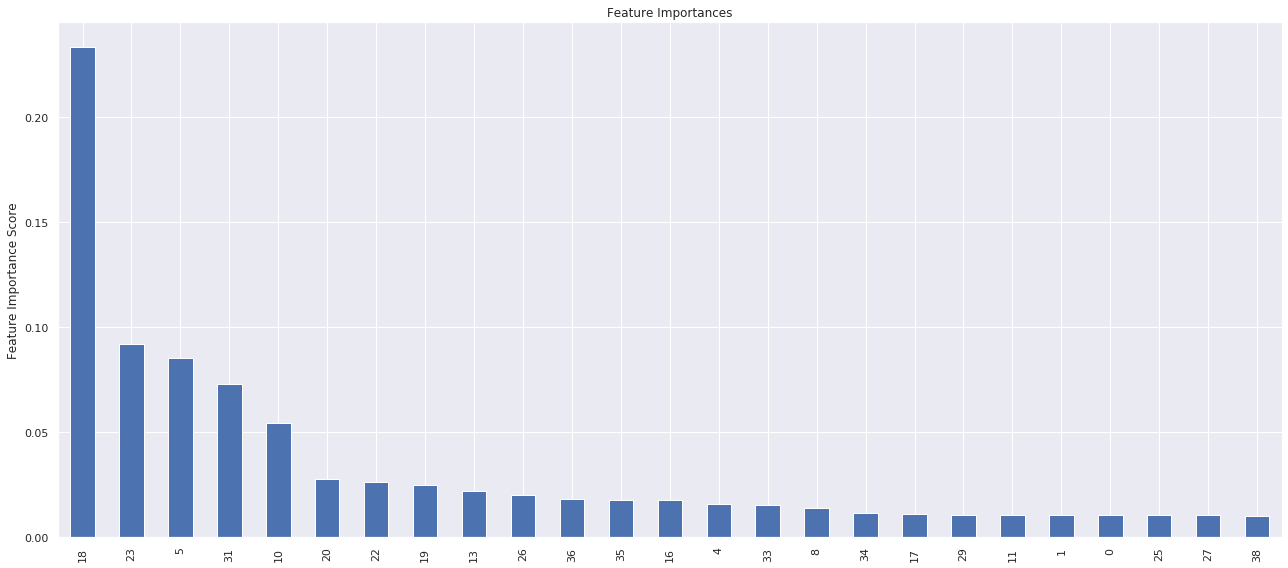

In [21]:
%%time

# Criando o modelo XGB com todas as otimizações
modeloXGB_v2 = XGBClassifier(learning_rate = 0.03, 
                             n_estimators = 2000, 
                             max_depth = grid_1.best_params_['max_depth'],
                             min_child_weight = grid_1.best_params_['min_child_weight'], 
                             gamma = grid_2.best_params_['gamma'], 
                             subsample = grid_3.best_params_['subsample'], 
                             colsample_bytree = grid_3.best_params_['colsample_bytree'],
                             reg_alpha = grid_4.best_params_['reg_alpha'],
                             objective = 'binary:logistic', 
                             n_jobs = -1,
                             scale_pos_weight = 1, 
                             seed = 123)

run_model(modeloXGB_v2, X, y)

# 0.05  e 1000            = XXX
# 0.01  e 2000            = XXX
# 0.03  e 2000 e seed=123 = 0.465131

#

In [22]:
# Visualizando o modelo XGBoost Otimizado
print(modeloXGB_v2)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0.1,
              learning_rate=0.03, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=1336, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
              silent=None, subsample=0.7, verbosity=1)


## 5. Submissions

In [29]:
# Preparando os dados de teste
new_teste = teste.drop(['target'], axis=1)
new_teste = scaler.fit_transform(new_teste)
new_teste.shape

(114393, 40)

In [32]:
submission = pd.read_csv('../dataset/sample_submission.csv')
submission['PredictedProb'] = modeloXGB_v2.predict_proba(new_teste)[:,1]
print(submission.shape)
submission.head()

(114393, 2)


,ID,PredictedProb
0,0,0.320861
1,1,0.951757
2,2,0.834998
3,7,0.637067
4,10,0.689229


In [33]:
submission.to_csv('../submission/submission_xgb_v.1.0.3.csv', index=False)

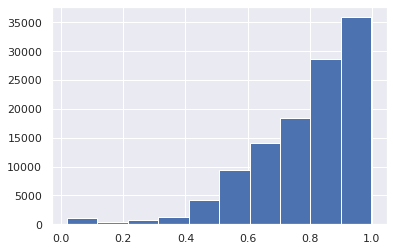

In [34]:
plt.hist(submission.PredictedProb)
plt.show()